In [34]:
!pip install lightgbm xgboost -q

In [35]:
import pandas as pd
import matplotlib.pyplot as plt 

dataset = pd.read_csv('./small-sample.csv', parse_dates=['reportts']) \
  .sort_values('reportts')

In [36]:
dataset

,reportts,acnum,pos,egtm,fltdes,dep,arr,pf,wai,nai,...,tol,tr,ttp,vb1,vb2,vorrc,vorv,votm,vsva,w14
0,2018-05-20 19:36:47,VQ-BDQ,1,132.144,171.0,UUDD,UNEE,0.43,0.0,0.0,...,NaN,NaN,36.0,0.2,0.2,69.4,NaN,NaN,0.785,1150.0
1,2018-05-22 01:48:50,VQ-BDQ,1,127.592,174.0,UNNT,UUDD,0.43,0.0,0.0,...,NaN,NaN,58.0,0.2,0.3,74.0,NaN,NaN,0.779,1100.0
2,2018-05-23 19:51:23,VQ-BDQ,1,128.712,171.0,UUDD,UNEE,0.43,0.0,0.0,...,NaN,NaN,35.0,0.2,0.4,68.3,NaN,NaN,0.782,1139.0
3,2018-05-25 01:07:05,VQ-BDQ,1,129.118,812.0,UNTT,UUDD,0.43,0.0,0.0,...,NaN,NaN,41.0,0.2,0.4,63.4,NaN,NaN,0.782,1182.0
4,2018-05-26 10:41:08,VQ-BDQ,1,129.008,3340.0,ULLI,UNNT,0.45,0.0,0.0,...,NaN,NaN,45.0,0.2,0.3,68.2,NaN,NaN,0.788,1150.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,2019-12-18 01:39:13,VQ-BDQ,1,110.861,6281.0,UHWW,RJAA,0.03,0.0,0.0,...,NaN,NaN,39.0,0.1,0.3,57.1,NaN,NaN,0.778,1166.0
119,2019-12-18 05:04:53,VQ-BDQ,1,110.643,6282.0,RJAA,UHWW,0.03,0.0,0.0,...,NaN,NaN,42.0,0.1,0.5,56.6,NaN,NaN,0.775,1078.0
120,2019-12-18 17:26:40,VQ-BDQ,1,110.586,6215.0,UHWW,UHPP,0.03,0.0,0.0,...,NaN,NaN,46.0,0.1,0.4,56.8,NaN,NaN,0.768,1194.0
121,2019-12-18 22:28:58,VQ-BDQ,1,110.581,6216.0,UHPP,UHWW,0.03,0.0,0.0,...,NaN,NaN,NaN,0.3,0.5,52.2,NaN,NaN,0.779,1228.0


In [37]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

In [38]:
Y = dataset[['egtm']]
# , 'n1_delt', 'n2_delt'

X = dataset.drop(columns=[
    'reportts', 'acnum', 'pos', 'dep', 'arr', 
    'egtm', 'fltdes', 'reportts',
    'dmusw', 'exswpn', 'reason'
]).fillna(-100)

X = X.loc[:, ~X.columns.str.contains('stw')]

In [39]:
def get_score_by_parameter(predict_field, alg='catboost'):
  y = Y[predict_field]

  x = X[y.notna()]

  y = y.dropna()
  
  X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
  
  # assert len(x) == len(y)
  # train_i = int(len(x) * 60 / 100)
  # X_train, y_train = x[0:train_i], y[0:train_i]
  # X_test, y_test = x[train_i:], y[train_i:]

  model = None
  if alg == 'catboost':
    model = CatBoostRegressor(iterations=200, random_state=42, verbose=False)
  elif alg == 'lightgbm':
    model = LGBMRegressor(random_state=42)
  elif alg == 'xgboost':
    model = XGBRegressor()
  elif alg == 'rand_forest':
    model = RandomForestRegressor(n_estimators=100, random_state=42)
  
  model.fit(X_train, y_train)
  predicted = model.predict(X_test)
  preds = pd.DataFrame({'y': y_test, 'pred': predicted})
  mse = mean_squared_error(y_test, predicted, squared=False)
  mae = mean_absolute_error(y_test, predicted)
  
  return mse, mae, model, preds

In [40]:
scores = pd.DataFrame(columns=["model", "parameter", "rmse", "mae"])
model_types = ["rand_forest", "lightgbm", "catboost", "xgboost"]

models = {}
preds = {}
output_parameters = Y.columns

for model in model_types:
  for param in output_parameters:
    mse, mae, result_model, pred = get_score_by_parameter(param, model)
    models[model + "_" + param] = result_model
    preds[model + "_" + param] = pred
    scores.loc[len(scores)] = [model, param, mse, mae]

scores

,model,parameter,rmse,mae
0,rand_forest,egtm,0.724442,0.312989
1,lightgbm,egtm,1.328316,0.805469
2,catboost,egtm,1.305995,0.777960
3,xgboost,egtm,2.262935,0.962787


[Text(0, 0, '0.724442'),
 Text(0, 0, '1.32832'),
 Text(0, 0, '1.306'),
 Text(0, 0, '2.26293')]

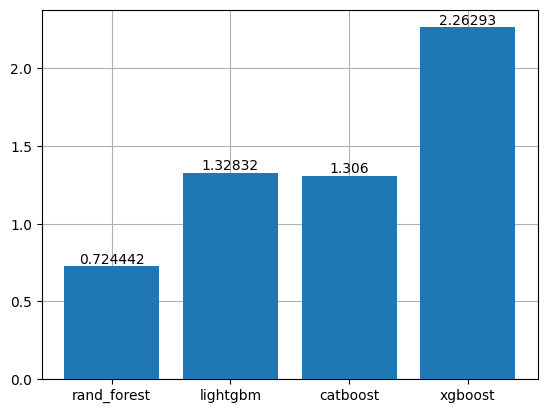

In [41]:
fig, ax = plt.subplots(1, 1)
ax.grid(zorder=0)
ax.bar(model_types, scores[scores['parameter'] == 'egtm']['rmse'], align='center', zorder=3)
ax.bar_label(ax.containers[0], label_type='edge')

In [43]:


preds['lightgbm_egtm']

,y,pred
18,122.729,125.116569
45,114.445,114.788576
47,114.498,114.391620
89,111.753,111.020520
4,129.008,125.733815
40,114.257,114.742871
62,114.091,114.090065
100,111.373,111.135755
31,123.664,120.566019
55,113.656,115.481014


1. Добавить линейную регрессию 
1. Разделить расчёт метрик по двигателям и фазам полёта
1. A321 - меньше допустимый запас egtm
1. В идеале EGTM +/- 2 градуса
1. Разделение по фазе полёта 
1. Построить корелляции каждого признака с таргетом
1. В дальнейшем использовать это для feature selection